## GPU Setting

In [21]:
import os
import tensorflow as tf

os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)




## Import Module

In [22]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline 
# Jupiter magic command to display plots in the notebook

from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras.callbacks import EarlyStopping
import keras
from keras import regularizers

In [23]:

print(tf.__version__) # tensorflow 버전 확인
print(keras.__version__) # keras 버전 확인
print(np.__version__) # numpy 버전 확인

2.9.1
2.9.0
1.23.5


In [24]:

# python version = 3.8.16
# pip install tensorflow-gpu==2.9.1
# pip install pandas
# pip install scikit-learn
# pip install seaborn
# numpy version = 1.24.2

# Train Data 
## loading and pre-processing

In [25]:
data = pd.read_csv("dataset/combined_train.csv") # Final train dataset

np.set_printoptions(precision=3, suppress=True)
data.head()
data = data.T
data_pd = pd.DataFrame(data)
data_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,351590,351591,351592,351593,351594,351595,351596,351597,351598,351599
brake_pressure,21.40,21.400000,21.400333,21.49950,21.400000,21.400833,21.5000,21.50,21.50,21.50,...,1.200000,1.200000,1.114702,1.100000,0.945241,0.000000,0.000000,0.000000,0.000000,0.000000
long_accel,0.11,0.119983,0.110033,0.11985,0.090067,0.100167,0.1199,0.11,0.11,0.11,...,-0.221737,-0.200000,-0.174411,-0.199905,-0.170152,-0.118536,-0.118580,-0.078555,-0.041355,-0.038600
steering_angle,24.60,24.600000,24.600000,24.60000,24.601334,24.798332,24.6000,24.60,24.60,24.60,...,-113.682431,-109.276261,-104.532206,-100.112034,-95.409102,-90.747176,-86.429219,-82.025404,-77.607135,-73.662074
wheel_speed,0.00,0.000000,0.000000,0.00000,0.000000,0.000000,0.0000,0.00,0.00,0.00,...,4.652171,4.602840,4.567095,4.531349,4.495603,4.459858,4.424112,4.406250,4.383871,4.348126


In [26]:
data = data_pd 
data = data.T
data = data[["brake_pressure", "steering_angle","long_accel", "wheel_speed"]]
data.head()

,brake_pressure,steering_angle,long_accel,wheel_speed
0,21.400000,24.600000,0.110000,0.0
1,21.400000,24.600000,0.119983,0.0
2,21.400333,24.600000,0.110033,0.0
3,21.499500,24.600000,0.119850,0.0
4,21.400000,24.601334,0.090067,0.0


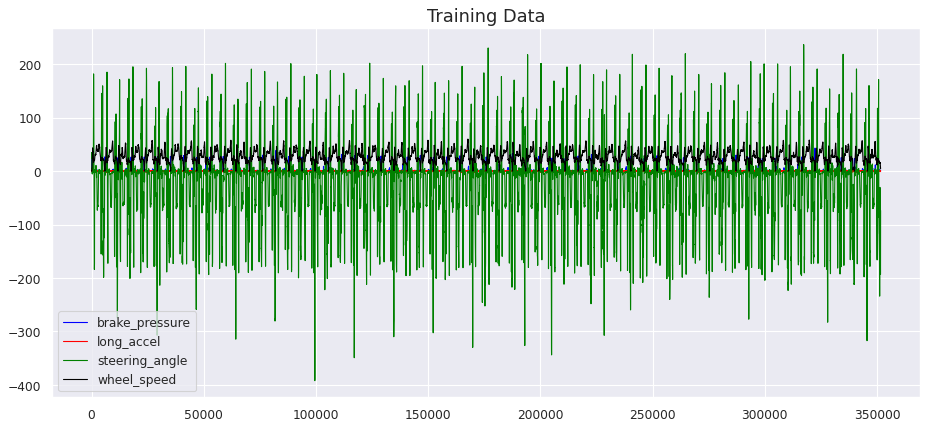

In [27]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80) # 그래프 크기 설정
ax.plot(data['brake_pressure'], label='brake_pressure', color='blue', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data['long_accel'], label='long_accel', color='red', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data['steering_angle'], label='steering_angle', color='green', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data['wheel_speed'], label='wheel_speed', color='black', animated = True, linewidth=1) # 그래프 그리기
plt.legend(loc='lower left') # 범례 표시
ax.set_title('Training Data', fontsize=16) # 그래프 제목
plt.show() # 그래프 출력

# Test data
## loading and pre-processing

In [28]:
data2 = pd.read_csv("dataset/final_test/train_25_bg_resampled_truncated.csv")

np.set_printoptions(precision=3, suppress=True)
data2.head()
data2 = data2.T
data2_pd = pd.DataFrame(data2)
data2_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,5850,5851,5852,5853,5854,5855,5856,5857,5858,5859
brake_pressure,23.60,23.60000,23.604401,23.700001,23.700001,23.688999,23.613203,23.715403,23.782397,23.700001,...,4.572145,4.674346,4.853092,4.978746,5.080947,5.183147,5.285348,5.387548,5.489748,5.683897
long_accel,0.12,0.11022,0.120000,0.120000,0.120000,0.120000,0.120000,0.115379,0.091760,0.103961,...,-0.750000,-0.750000,-0.765309,-0.785749,-0.773811,-0.778315,-0.780000,-0.771245,-0.770000,-0.770000
steering_angle,3.90,3.90000,3.900000,3.900000,3.882397,3.722004,3.900000,3.900000,3.935206,4.060393,...,3.300000,3.300000,3.300000,3.300000,3.300000,3.300000,3.470695,3.324904,3.300000,3.300000
wheel_speed,0.00,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,3.807364,3.734784,3.670909,3.656250,3.605658,3.541783,3.477908,3.414033,3.322111,3.312500


In [29]:
data2 = data2_pd 
data2 = data2.T
data2 = data2[["brake_pressure", "steering_angle","long_accel", "wheel_speed"]]


data2.head()

,brake_pressure,steering_angle,long_accel,wheel_speed
0,23.600000,3.900000,0.12000,0.0
1,23.600000,3.900000,0.11022,0.0
2,23.604401,3.900000,0.12000,0.0
3,23.700001,3.900000,0.12000,0.0
4,23.700001,3.882397,0.12000,0.0


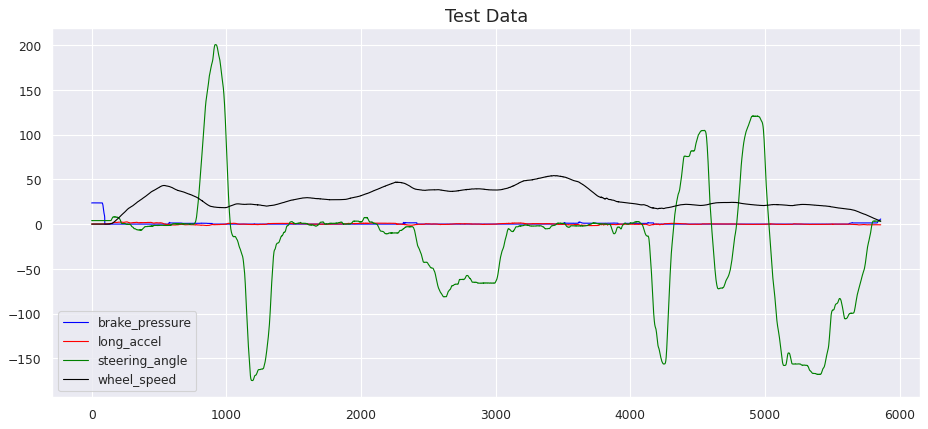

In [30]:
fig, ax = plt.subplots(figsize=(14, 6), dpi=80) # 그래프 크기 설정
ax.plot(data2['brake_pressure'], label='brake_pressure', color='blue', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data2['long_accel'], label='long_accel', color='red', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data2['steering_angle'], label='steering_angle', color='green', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data2['wheel_speed'], label='wheel_speed', color='black', animated = True, linewidth=1) # 그래프 그리기
plt.legend(loc='lower left') # 범례 표시
ax.set_title('Test Data', fontsize=16) # 그래프 제목
plt.show() # 그래프 출력

### Validation set

In [31]:
data3 = pd.read_csv("dataset/combined_valid.csv")

np.set_printoptions(precision=3, suppress=True)
data3.head()
data3 = data3.T
data3_pd = pd.DataFrame(data3)
data3_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,70310,70311,70312,70313,70314,70315,70316,70317,70318,70319
brake_pressure,29.10,29.200001,29.200001,29.200001,29.200001,29.200001,29.200001,29.160561,29.145075,29.149292,...,7.300000,7.30000,7.300000,7.300000,7.300000,7.300000,7.371095,7.312619,7.300000,7.300000
long_accel,0.12,0.118873,0.102254,0.114929,0.094507,0.104366,0.100142,0.120000,0.120000,0.125071,...,0.077338,0.08000,0.081785,0.105553,0.086148,0.090962,0.092890,0.107476,0.100367,0.106009
steering_angle,-3.30,-3.288731,-3.122537,-3.300000,-3.232389,-3.084514,-3.300000,-3.181680,-3.000000,-3.050708,...,8.846757,8.72067,8.888098,8.744474,8.900000,8.790381,8.842190,9.162143,9.496333,9.400000
wheel_speed,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.102069,0.09375,0.093750,0.093750,0.093750,0.093750,0.093750,0.093750,0.093750,0.093750


In [32]:
data3 = data3_pd 
data3 = data3.T
data3 = data3[["brake_pressure", "steering_angle","long_accel", "wheel_speed"]]


data3.head()

,brake_pressure,steering_angle,long_accel,wheel_speed
0,29.100000,-3.300000,0.120000,0.0
1,29.200001,-3.288731,0.118873,0.0
2,29.200001,-3.122537,0.102254,0.0
3,29.200001,-3.300000,0.114929,0.0
4,29.200001,-3.232389,0.094507,0.0


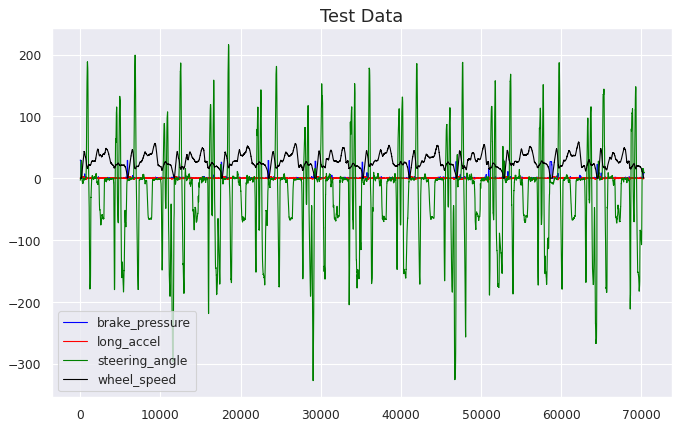

In [33]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=80) # 그래프 크기 설정
ax.plot(data3['brake_pressure'], label='brake_pressure', color='blue', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data3['long_accel'], label='long_accel', color='red', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data3['steering_angle'], label='steering_angle', color='green', animated = True, linewidth=1) # 그래프 그리기
ax.plot(data3['wheel_speed'], label='wheel_speed', color='black', animated = True, linewidth=1) # 그래프 그리기
plt.legend(loc='lower left') # 범례 표시
ax.set_title('Test Data', fontsize=16) # 그래프 제목
plt.show() # 그래프 출력

In [34]:
train = data
print("Training dataset shape:", train.shape) # 훈련 데이터의 크기
test = data2
print("Test dataset shape:", test.shape) # 테스트 데이터의 크기
valid = data3
print("Validation dataset shape:", valid.shape) # valid 데이터의 크기

Training dataset shape: (351600, 4)
Test dataset shape: (5860, 4)
Validation dataset shape: (70320, 4)


In [35]:
# normalize the data
# scaler = MinMaxScaler() # 스케일러 생성
scaler = StandardScaler() # 스케일러 생성
X_train = scaler.fit_transform(train) # 훈련 데이터 스케일링
# X_train = np.array(train)
X_test = scaler.fit_transform(test) # 테스트 데이터 스케일링
# X_test = np.array(test)
X_valid = scaler.fit_transform(valid) # valid 데이터 스케일링
# X_valid = np.array(valid)

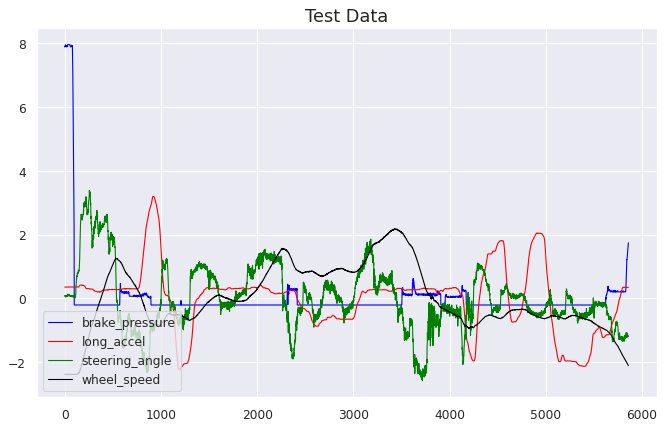

In [36]:
# X_train 에 대한 plot
fig, ax = plt.subplots(figsize=(10, 6), dpi=80) # 그래프 크기 설정
ax.plot(X_test[:,0], label='brake_pressure', color='blue', animated = True, linewidth=1) # 그래프 그리기
ax.plot(X_test[:,1], label='long_accel', color='red', animated = True, linewidth=1) # 그래프 그리기
ax.plot(X_test[:,2], label='steering_angle', color='green', animated = True, linewidth=1) # 그래프 그리기
ax.plot(X_test[:,3], label='wheel_speed', color='black', animated = True, linewidth=1) # 그래프 그리기
plt.legend(loc='lower left') # 범례 표시
ax.set_title('Test Data', fontsize=16) # 그래프 제목
plt.show() # 그래프 출력


In [37]:
# reshape inputs for LSTM [samples, timesteps, features]
timesteps =20
X_train = X_train.reshape(-1, timesteps, X_train.shape[1])
print("Training data shape:", X_train.shape) # 훈련 데이터의 크기 출력
X_test = X_test.reshape(-1, timesteps, X_test.shape[1])
print("Test data shape:", X_test.shape) # 테스트 데이터의 크기 출력
X_valid = X_valid.reshape(-1, timesteps, X_valid.shape[1])
print("Validation data shape:", X_valid.shape) # valid 데이터의 크기 출력

Training data shape: (17580, 20, 4)
Test data shape: (293, 20, 4)
Validation data shape: (3516, 20, 4)


In [38]:
def autoencoder_model(X):
    # 입력 데이터의 sequence 길이와 feature 개수
    sequence_length, feature_dim = X.shape[1], X.shape[2]

    # Encoder
    inputs = Input(shape=(sequence_length, feature_dim), name='encoder_input')
    encoded = LSTM(128, return_sequences=True,activation='tanh', name='encoder_lstm_1')(inputs)
    encoded = LSTM(64, return_sequences=True,activation='tanh', name='encoder_lstm_2')(encoded)
    encoded = LSTM(32, return_sequences=False,activation='tanh', name='encoder_lstm_3')(encoded)
    encoded = Dense(3, name='encoder_dense')(encoded)

    # Decoder
    decoded = RepeatVector(sequence_length, name='decoder_repeat_vector')(encoded) 
    decoded = LSTM(32, return_sequences=True,activation='tanh', name='decoder_lstm_1')(decoded)
    decoded = LSTM(64, return_sequences=True,activation='tanh', name='decoder_lstm_2')(decoded)
    decoded = LSTM(128, return_sequences=True,activation='tanh', name='decoder_lstm_3')(decoded)
    output = TimeDistributed(Dense(feature_dim), name='decoder_timedistributed_dense')(decoded)

    # Autoencoder
    model = Model(inputs, output, name='lstm_autoencoder')
    model.compile(optimizer='adam', loss='mse')
    
    return model


In [39]:
# create the autoencoder model
model = autoencoder_model(X_train) # 오토인코더 모델 생성
model.compile(optimizer='adam', loss='mse', metrics=['accuracy']) # 모델 컴파일
model.summary() # 모델 요약

Model: "lstm_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 20, 4)]           0         
                                                                 
 encoder_lstm_1 (LSTM)       (None, 20, 128)           68096     
                                                                 
 encoder_lstm_2 (LSTM)       (None, 20, 64)            49408     
                                                                 
 encoder_lstm_3 (LSTM)       (None, 32)                12416     
                                                                 
 encoder_dense (Dense)       (None, 3)                 99        
                                                                 
 decoder_repeat_vector (Repe  (None, 20, 3)            0         
 atVector)                                                       
                                                  

In [ ]:
# fit the model to the data
nb_epochs = 100 # 에포크 수
batch_size =64 # 배치 크기
print("Training the model...")
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size,
                    validation_data=(X_valid, X_valid), verbose=0).history # 모델 훈련


model.save('timestep20.h5')
print("Saved model to disk")

In [50]:
import tensorflow as tf

loaded_model = tf.keras.models.load_model('timestep20_standard.h5')
print("Model loaded!!")
loaded_model.summary() # 모델 요약

Model loaded!!
Model: "lstm_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 20, 4)]           0         
                                                                 
 encoder_lstm_1 (LSTM)       (None, 20, 128)           68096     
                                                                 
 encoder_lstm_2 (LSTM)       (None, 20, 64)            49408     
                                                                 
 encoder_lstm_3 (LSTM)       (None, 32)                12416     
                                                                 
 encoder_dense (Dense)       (None, 3)                 99        
                                                                 
 decoder_repeat_vector (Repe  (None, 20, 3)            0         
 atVector)                                                       
                                   

In [51]:
# keras.utils.plot_model(loaded_model, "LSTM_Autoencoder.png")

In [52]:
print("Evaluate on test data")
results = loaded_model.evaluate(X_test, X_test, batch_size=256) # 모델 평가
print("test loss, test acc:", results)

Evaluate on test data
2/2 [==============================] - 1s 4ms/step - loss: 0.0072 - accuracy: 0.9563
test loss, test acc: [0.0071560172364115715, 0.956313967704773]


In [53]:
# 위에 정의한 autoencoder 에서 encoder 부분만 떼서 새로운 모델 생성
encoder = Model(inputs=loaded_model.input, outputs=loaded_model.get_layer('encoder_dense').output)
encoder.summary()

# encoder 모델로 테스트 데이터를 인코딩
encoded_data = encoder.predict(X_test)
print("Encoded data shape:", encoded_data.shape) # 인코딩된 데이터의 크기 출력
print(encoded_data)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 20, 4)]           0         
                                                                 
 encoder_lstm_1 (LSTM)       (None, 20, 128)           68096     
                                                                 
 encoder_lstm_2 (LSTM)       (None, 20, 64)            49408     
                                                                 
 encoder_lstm_3 (LSTM)       (None, 32)                12416     
                                                                 
 encoder_dense (Dense)       (None, 3)                 99        
                                                                 
Total params: 130,019
Trainable params: 130,019
Non-trainable params: 0
_________________________________________________________________
10/10 [==============================] - 1s 2ms/step


In [54]:
scaler = MinMaxScaler() # 스케일러 생성
encoded_data = scaler.fit_transform(encoded_data) # 인코딩된 데이터 스케일링
print(encoded_data)

[[0.237 0.996 0.161]
 [0.236 0.999 0.159]
 [0.237 1.    0.162]
 [0.237 0.996 0.16 ]
 [0.259 0.884 0.412]
 [0.262 0.534 0.447]
 [0.213 0.522 0.481]
 [0.178 0.521 0.505]
 [0.035 0.486 0.616]
 [0.026 0.457 0.629]
 [0.    0.416 0.661]
 [0.028 0.388 0.701]
 [0.042 0.322 0.604]
 [0.036 0.34  0.795]
 [0.24  0.329 0.573]
 [0.212 0.273 0.574]
 [0.192 0.225 0.606]
 [0.253 0.242 0.648]
 [0.273 0.207 0.63 ]
 [0.288 0.179 0.655]
 [0.298 0.134 0.666]
 [0.299 0.102 0.734]
 [0.338 0.158 0.894]
 [0.439 0.111 0.602]
 [0.417 0.104 0.764]
 [0.449 0.074 0.728]
 [0.537 0.195 1.   ]
 [0.69  0.301 0.566]
 [0.707 0.323 0.542]
 [0.741 0.382 0.521]
 [0.754 0.422 0.397]
 [0.708 0.412 0.407]
 [0.653 0.384 0.449]
 [0.628 0.378 0.497]
 [0.641 0.408 0.461]
 [0.633 0.421 0.426]
 [0.612 0.42  0.443]
 [0.609 0.435 0.423]
 [0.593 0.445 0.425]
 [0.593 0.488 0.462]
 [0.588 0.545 0.512]
 [0.568 0.588 0.583]
 [0.548 0.636 0.619]
 [0.508 0.65  0.675]
 [0.418 0.637 0.828]
 [0.372 0.652 0.935]
 [0.36  0.655 0.943]
 [0.36  0.636

In [55]:
import csv
import os

path = os.getcwd()
#fields Names
fields = ['r', 'g', 'b']

with open('rgb_bg.csv', 'w', newline='') as f:
    write = csv.writer(f)
    write.writerow(fields)
    write.writerows(encoded_data)

In [56]:
import pandas as pd
import numpy as np
from scipy import interpolate
import os

# RGB 데이터를 CSV 파일로부터 로드
df = pd.read_csv('rgb_bg.csv')

# 원본 RGB 값
original_rgb = df.values

# 원본 데이터 길이
original_length = original_rgb.shape[0]

# 목표 길이
target_length = 2419

# 선형 보간 함수 생성
func = interpolate.interp1d(np.arange(original_length), original_rgb, axis=0)

# 새로운 인덱스 (선형으로 간격을 조절)
new_index = np.linspace(0, original_length-1, target_length)

# 보간을 수행하여 새로운 RGB 값을 얻음
new_rgb = func(new_index)

# 결과를 DataFrame으로 변환
df_new = pd.DataFrame(new_rgb, columns=df.columns)

# 저장할 폴더 이름
folder_name = 'interpolate'

# 해당 폴더가 없다면 생성
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

# DataFrame을 새로운 CSV 파일로 저장
df_new.to_csv(f'{folder_name}/rgb_bg_interpolated.csv', index=False)


In [57]:
import pandas as pd
from sklearn.cluster import SpectralClustering

# 데이터 불러오기
rgb_df = pd.read_csv("/home/bg/lstm_autoencoder_trajectory/interpolate/rgb_bg_interpolated.csv")

# 클러스터의 수 설정
n_clusters = 7

# Spectral Clustering 객체 생성 및 적용
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=0)
clusters = clustering.fit_predict(rgb_df)

# 클러스터링된 각 그룹의 평균 RGB 값을 계산
clustered_rgb = []
for i in range(n_clusters):
    cluster_mean = rgb_df[clusters == i].mean()
    clustered_rgb.append(cluster_mean)

# 원본 데이터를 클러스터링된 평균 RGB 값으로 대체
new_rgb_df = pd.DataFrame([clustered_rgb[cluster] for cluster in clusters], columns=rgb_df.columns)

# 결과를 새로운 CSV 파일에 저장
new_rgb_df.to_csv('/home/bg/lstm_autoencoder_trajectory/clustered/test.csv', index=False)

print("파일에 저장되었습니다.")


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fc654041d30>
Traceback (most recent call last):
  File "/home/bg/anaconda3/envs/lstm_auto/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/bg/anaconda3/envs/lstm_auto/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/bg/anaconda3/envs/lstm_auto/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/bg/anaconda3/envs/lstm_auto/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._fi

파일에 저장되었습니다.


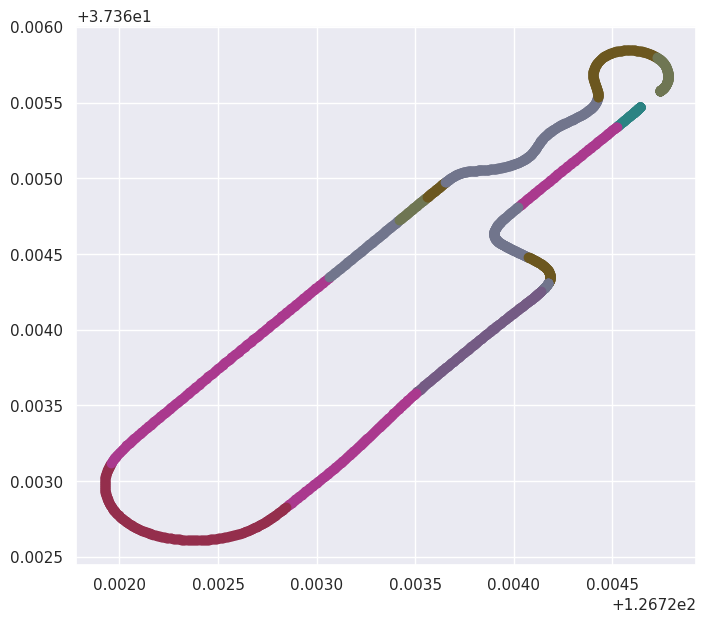

In [58]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import io
import random

gps_df = pd.read_csv("0320GPS_POSITION.csv")
rgb_df = pd.read_csv("clustered/test.csv")

fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(111)


# 길이가 동일한 경우
for i in range(len(rgb_df['r'])):
    ax.scatter(gps_df['longitude'][i], gps_df['latitude'][i], marker='o', color = [rgb_df['r'][i], rgb_df['g'][i], rgb_df['b'][i], 1])

plt.show()
